In [51]:
import pandas as pd   
import numpy as np 
import glob

data_path = 'E:/clusterdata-2011-2/task_usage/part-00000-of-00500.csv'

headers = ['start time',
    'end time',
    'job ID',
    'task index',
    'machine ID',
    'mean CPU usage rate',
    'canonical memory usage',
    'assigned memory usage',
    'unmapped page cache memory usage',
    'total page cache memory usage',
    'maximum memory usage',
    'mean disk I/O time',
    'mean local disk space used',
    'max CPU usage',
    'max disk IO time',
    'CPI',
    'memory accesses per instruction (MAI)',
    'sample portion',
    'aggregation type',
    'sampled CPU usage']

trace_dataframe = pd.read_csv(data_path, header=None, index_col=False,names=headers,delimiter=',')

base_dir='E:/clusterdata-2011-2/task_usage/'
all_fnames=glob.glob(base_dir+"/*.csv")

trace_dataframe.head()


,start time,end time,job ID,task index,machine ID,mean CPU usage rate,canonical memory usage,assigned memory usage,unmapped page cache memory usage,total page cache memory usage,maximum memory usage,mean disk I/O time,mean local disk space used,max CPU usage,max disk IO time,CPI,memory accesses per instruction (MAI),sample portion,aggregation type,sampled CPU usage
0,600000000,900000000,3418309,0,4155527081,0.001562,0.06787,0.07568,0.001156,0.001503,0.06787,0.000003,0.000187,0.039670,0.000357,2.445,0.007243,0,1,0.0
1,600000000,900000000,3418309,1,329150663,0.001568,0.06787,0.07556,0.000319,0.000700,0.06787,0.000006,0.000188,0.033020,0.000929,2.100,0.005791,0,1,0.0
2,600000000,900000000,3418314,0,3938719206,0.000307,0.08044,0.09521,0.000282,0.000670,0.08044,0.000005,0.000184,0.023770,0.000786,5.588,0.020800,0,1,0.0
3,600000000,900000000,3418314,1,351618647,0.000300,0.08044,0.09521,0.000537,0.000870,0.08044,0.000010,0.000183,0.007919,0.002285,5.198,0.020380,0,1,0.0
4,600000000,900000000,3418319,0,431052910,0.000461,0.07715,0.08740,0.000625,0.000852,0.07715,0.000002,0.000204,0.005112,0.000215,2.937,0.009449,0,1,0.0


In [52]:
def google_part_clean(fname): 
    headers = ['start time',
    'end time',
    'job ID',
    'task index',
    'machine ID',
    'mean CPU usage rate',
    'canonical memory usage',
    'assigned memory usage',
    'unmapped page cache memory usage',
    'total page cache memory usage',
    'maximum memory usage',
    'mean disk I/O time',
    'mean local disk space used',
    'max CPU usage',
    'max disk IO time',
    'CPI',
    'memory accesses per instruction (MAI)',
    'sample portion',
    'aggregation type',
    'sampled CPU usage']

    trace_dataframe = pd.read_csv(fname, header=None, index_col=False,names=headers,delimiter=',')
    
    cols_to_drop=['end time',
    'job ID',
    'task index',
    'machine ID',
    'canonical memory usage',
    'unmapped page cache memory usage',
    'total page cache memory usage',
    'maximum memory usage',
    'mean local disk space used',
    'max CPU usage',
    'max disk IO time',
    'CPI',
    'memory accesses per instruction (MAI)',
    'sample portion',
    'aggregation type',
    'sampled CPU usage']
    time_grouped=trace_dataframe.groupby('start time').sum()
    time_grouped.drop(cols_to_drop, axis=1, inplace=True)
    time_grouped=time_grouped.iloc[time_grouped.index%3e8==0]

    return time_grouped

In [54]:
clean_df_list=[]

In [55]:
for f in all_fnames:
    x=google_part_clean(f)
    clean_df_list.append(x)

clean_df=pd.concat(clean_df_list)

In [81]:
clean_df.to_csv('combined_trace_clean.csv')

In [70]:
clean_df['assigned memory usage'].max()

232541.2435381987

In [72]:
clean_df.shape
#clean_df[clean_df['assigned memory usage']==clean_df['assigned memory usage'].max()]
max_row=558600000000 #row 1860

,mean CPU usage rate,assigned memory usage,mean disk I/O time
start time,,,
558600000000,2163.605617,232541.243538,334.859738


In [79]:
clean_df[1859:1862]
clean_df.iloc[1860]['assigned memory usage']=(clean_df.iloc[1859]['assigned memory usage']+clean_df.iloc[1861]['assigned memory usage'])/2

In [99]:
clean_df.drop('mean disk I/O time', axis=1, inplace=True)

In [100]:
clean_df.to_csv('combined_trace_noIO.csv')

<AxesSubplot:xlabel='start time'>

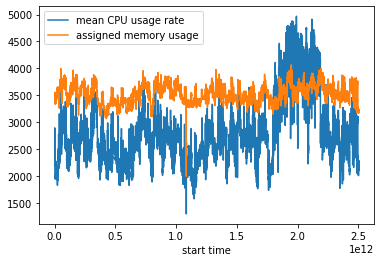

In [101]:
clean_df.plot()

In [140]:
#build model
import matplotlib.pyplot as plt 
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, MaxPooling1D
from keras import backend as K
from keras.layers import LeakyReLU, Conv1D, ConvLSTM2D, Flatten, GlobalAveragePooling1D

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

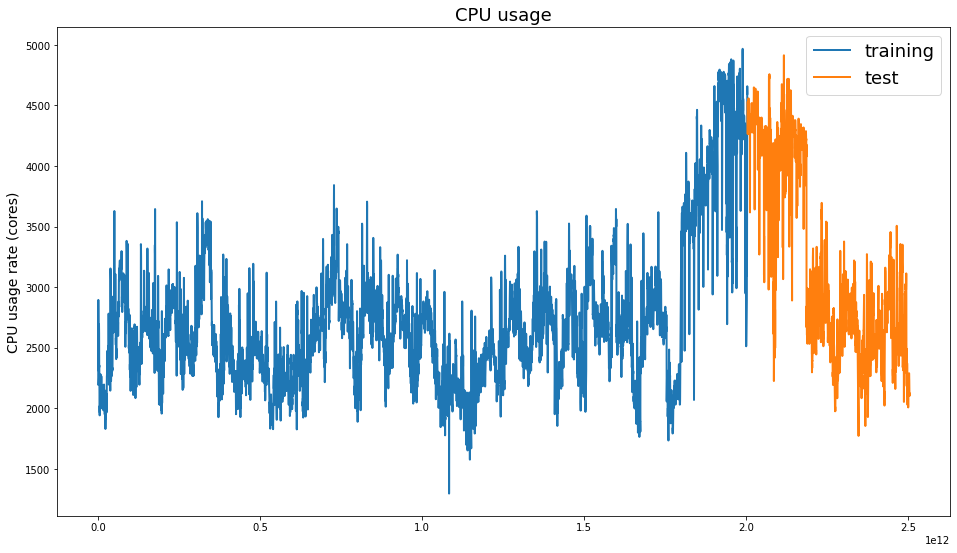

In [110]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
def line_plot(line1, line2, label1=None, label2=None, title=''):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=2)
    ax.plot(line2, label=label2, linewidth=2)
    ax.set_ylabel('CPU usage rate (cores)', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)

train, test = train_test_split(clean_df, test_size=0.2)
line_plot(train['mean CPU usage rate'], test['mean CPU usage rate'], 'training', 'test', 'CPU usage')

In [191]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with
        respect to first entry.
    """
    return df / df.iloc[0] - 1
def extract_window_data(df, window=8, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of
        length `window`.
    """
    window_data = []
    for idx in range(len(df) - window):
        tmp = df[idx: (idx + window)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)
def prepare_data(df, window=8, zero_base=True, test_size=0.2):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window, zero_base)
    X_test = extract_window_data(test_data, window, zero_base)
    
    # extract targets
    y_train = train_data['mean CPU usage rate'][window:].values
    y_test = test_data['mean CPU usage rate'][window:].values
    if zero_base:
        y_train = y_train / train_data['mean CPU usage rate'][:-window].values - 1
        y_test = y_test / test_data['mean CPU usage rate'][:-window].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test
train, test, X_train, X_test, y_train, y_test = prepare_data(clean_df)

In [192]:
X_train.shape

(6674, 8, 2)

In [188]:
modelMSE.save('C:/Users/lesap/Documents/GitHub/ConvolutionalCloudWorkloadAnalysis/lstmModel')
modelC.save('C:/Users/lesap/Documents/GitHub/ConvolutionalCloudWorkloadAnalysis')

INFO:tensorflow:Assets written to: C:/Users/lesap/Documents/GitHub/ConvolutionalCloudWorkloadAnalysis/lstmModel\assets
INFO:tensorflow:Assets written to: C:/Users/lesap/Documents/GitHub/ConvolutionalCloudWorkloadAnalysis\assets


In [195]:
def build_lstm_model(input_data, output_size, loss, neurons=64,
                     activ_func='tanh', dropout=0.2,
                     optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=(
              input_data.shape[1], input_data.shape[2])))
    #model.add(LSTM(128))
    model.add(LSTM(64))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    #model.add(Activation(activ_func))
    model.add(LeakyReLU(alpha=.1))
    model.compile(loss=loss, optimizer=optimizer)
    return model
modelMSE = build_lstm_model(X_train, output_size=1, loss='mse')
historyMSE = modelMSE.fit(X_train, y_train, epochs=300, batch_size=128)

=====] - 2s 45ms/step - loss: 0.0032
Epoch 60/300
53/53 [==============================] - 3s 52ms/step - loss: 0.0032
Epoch 61/300
53/53 [==============================] - 3s 57ms/step - loss: 0.0031
Epoch 62/300
53/53 [==============================] - 3s 55ms/step - loss: 0.0032
Epoch 63/300
53/53 [==============================] - 2s 46ms/step - loss: 0.0031
Epoch 64/300
53/53 [==============================] - 3s 48ms/step - loss: 0.0031
Epoch 65/300
53/53 [==============================] - 2s 45ms/step - loss: 0.0031
Epoch 66/300
53/53 [==============================] - 2s 44ms/step - loss: 0.0031
Epoch 67/300
53/53 [==============================] - 2s 44ms/step - loss: 0.0031
Epoch 68/300
53/53 [==============================] - 3s 52ms/step - loss: 0.0031
Epoch 69/300
53/53 [==============================] - 2s 46ms/step - loss: 0.0031
Epoch 70/300
53/53 [==============================] - 2s 45ms/step - loss: 0.0031
Epoch 71/300
53/53 [==============================] - 2s 45ms

In [182]:
modelMAE = build_lstm_model(X_train, output_size=1, loss='mae')
historyMAE = modelMAE.fit(X_train, y_train, epochs=300, batch_size=128)

Epoch 1/300
53/53 [==============================] - 2s 38ms/step - loss: 0.0740
Epoch 2/300
53/53 [==============================] - 2s 45ms/step - loss: 0.0684
Epoch 3/300
53/53 [==============================] - 3s 57ms/step - loss: 0.0627
Epoch 4/300
53/53 [==============================] - 3s 55ms/step - loss: 0.0569
Epoch 5/300
53/53 [==============================] - 3s 55ms/step - loss: 0.0548
Epoch 6/300
53/53 [==============================] - 3s 58ms/step - loss: 0.0524
Epoch 7/300
53/53 [==============================] - 3s 61ms/step - loss: 0.0489
Epoch 8/300
53/53 [==============================] - 3s 52ms/step - loss: 0.0469
Epoch 9/300
53/53 [==============================] - 3s 54ms/step - loss: 0.0452
Epoch 10/300
53/53 [==============================] - 3s 59ms/step - loss: 0.0442
Epoch 11/300
53/53 [==============================] - 3s 57ms/step - loss: 0.0432
Epoch 12/300
53/53 [==============================] - 3s 54ms/step - loss: 0.0429
Epoch 13/300
53/53 [=====

KeyboardInterrupt: 

In [196]:
def build_conv_model(trainX, n_outputs, loss_f, actF):

    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]
    #n_outputs=1
    model=Sequential()

    model.add(keras.layers.Conv1D(64, 1, 1, padding='valid', activation=actF, input_shape=(n_timesteps,n_features)))#(trainX))
    model.add(keras.layers.Conv1D(64, 3, 1, padding='causal', dilation_rate=1, activation=actF))
    model.add(keras.layers.Conv1D(64, 1, 1, padding='causal', dilation_rate=2, activation=actF))
    model.add(keras.layers.Conv1D(64, 3, 1, padding='causal', dilation_rate=4, activation=actF))
    model.add(keras.layers.Conv1D(64, 1, 1, padding='causal', dilation_rate=8, activation=actF))
    model.add(keras.layers.Conv1D(64, 3, 1, padding='causal', dilation_rate=16, activation=actF))
    model.add(keras.layers.Conv1D(64, 1, 1, padding='causal', dilation_rate=32, activation=actF))
    model.add(keras.layers.Conv1D(64, 3, 1, padding='causal', dilation_rate=64, activation=actF))
    #merge_x = keras.layers.add([x1, x2, x3, x4])
    model.add(GlobalAveragePooling1D())
    model.add(keras.layers.Flatten())
    model.add(Dropout(0.5))
    #model.add(keras.layers.Dense(128, activation='sigmoid'))
    model.add(keras.layers.Dense(128, activation='tanh'))
    #model.add(keras.layers.Dense(128, activation='tanh'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.add(LeakyReLU(alpha=.1))
    model.compile(loss=loss_f, optimizer='adam')
    return model 

modelC = build_conv_model(X_train, n_outputs=1, loss_f='mse', actF='tanh')
historyC = modelC.fit(X_train, y_train, epochs=200, batch_size=128)

Epoch 1/200
53/53 [==============================] - 3s 53ms/step - loss: 0.0253
Epoch 2/200
53/53 [==============================] - 3s 57ms/step - loss: 0.0113
Epoch 3/200
53/53 [==============================] - 3s 57ms/step - loss: 0.0094
Epoch 4/200
53/53 [==============================] - 3s 57ms/step - loss: 0.0087
Epoch 5/200
53/53 [==============================] - 3s 56ms/step - loss: 0.0085
Epoch 6/200
53/53 [==============================] - 3s 60ms/step - loss: 0.0085
Epoch 7/200
53/53 [==============================] - 3s 57ms/step - loss: 0.0081
Epoch 8/200
53/53 [==============================] - 3s 57ms/step - loss: 0.0081
Epoch 9/200
53/53 [==============================] - 3s 57ms/step - loss: 0.0080
Epoch 10/200
53/53 [==============================] - 3s 57ms/step - loss: 0.0080
Epoch 11/200
53/53 [==============================] - 3s 57ms/step - loss: 0.0081
Epoch 12/200
53/53 [==============================] - 3s 58ms/step - loss: 0.0080
Epoch 13/200
53/53 [=====

In [180]:
modelCmae = build_conv_model(X_train, n_outputs=1, loss_f='mae', actF='tanh')
historyCmae = modelCmae.fit(X_train, y_train, epochs=64, batch_size=64)

Epoch 1/64
105/105 [==============================] - 3s 24ms/step - loss: 0.0898
Epoch 2/64
105/105 [==============================] - 3s 28ms/step - loss: 0.0763
Epoch 3/64
105/105 [==============================] - 4s 39ms/step - loss: 0.0751
Epoch 4/64
105/105 [==============================] - 4s 38ms/step - loss: 0.0750
Epoch 5/64
105/105 [==============================] - 4s 42ms/step - loss: 0.0735
Epoch 6/64
105/105 [==============================] - 4s 37ms/step - loss: 0.0718
Epoch 7/64
105/105 [==============================] - 4s 37ms/step - loss: 0.0714
Epoch 8/64
105/105 [==============================] - 4s 38ms/step - loss: 0.0693
Epoch 9/64
105/105 [==============================] - 4s 38ms/step - loss: 0.0697
Epoch 10/64
105/105 [==============================] - 4s 38ms/step - loss: 0.0687
Epoch 11/64
105/105 [==============================] - 4s 37ms/step - loss: 0.0691
Epoch 12/64
105/105 [==============================] - 4s 39ms/step - loss: 0.0687
Epoch 13/64
1

0.8168330348696179
0.6536447611261625


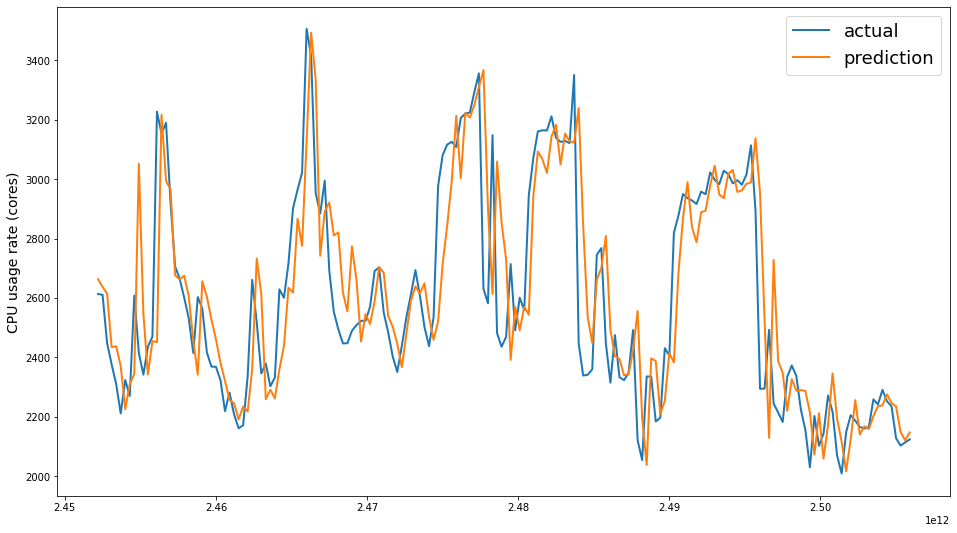

In [198]:
window=8
target_col='mean CPU usage rate'
targets = test[target_col][window:]


preds = modelMSE.predict(X_train).squeeze()
predsTest = modelMSE.predict(X_test).squeeze()

print(r2_score(preds, y_train))
print(r2_score(predsTest, y_test))

# convert change predictions back to actual price
predsTest = test['mean CPU usage rate'].values[:-window] * (predsTest + 1)
predsTest = pd.Series(index=targets.index, data=predsTest)

n = 180
line_plot(targets[-n:], predsTest[-n:], 'actual', 'prediction')

-0.623762250811926
-1.0017308479327065


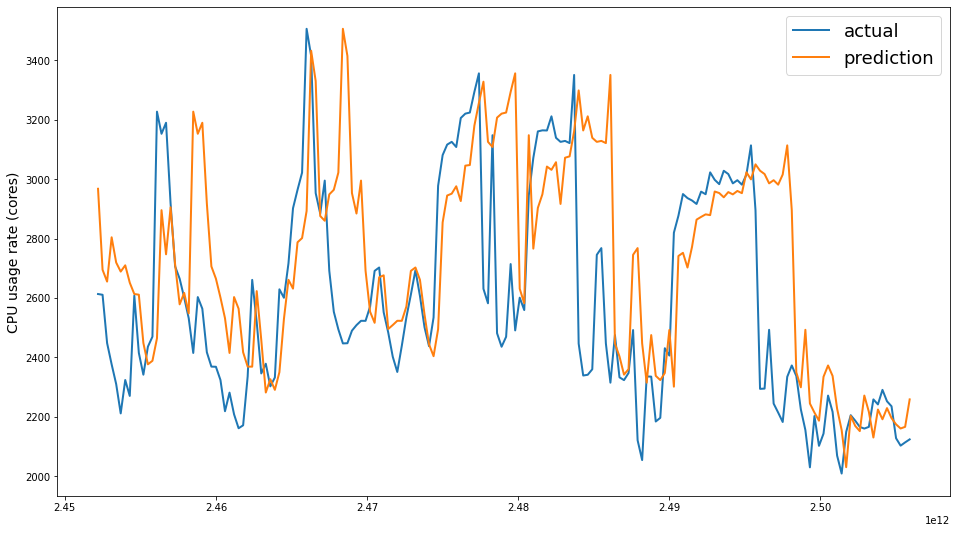

In [197]:
window=8
target_col='mean CPU usage rate'
targets = test[target_col][window:]


predsC = modelC.predict(X_train).squeeze()
predsTestC = modelC.predict(X_test).squeeze()

print(r2_score(predsC, y_train))
print(r2_score(predsTestC, y_test))

# convert change predictions back to actual price
predsTestC = test['mean CPU usage rate'].values[:-window] * (predsTestC + 1)
predsTestC = pd.Series(index=targets.index, data=predsTestC)

n = 180
line_plot(targets[-n:], predsTestC[-n:], 'actual', 'prediction')

-0.428603463251622
-0.7708102350946728


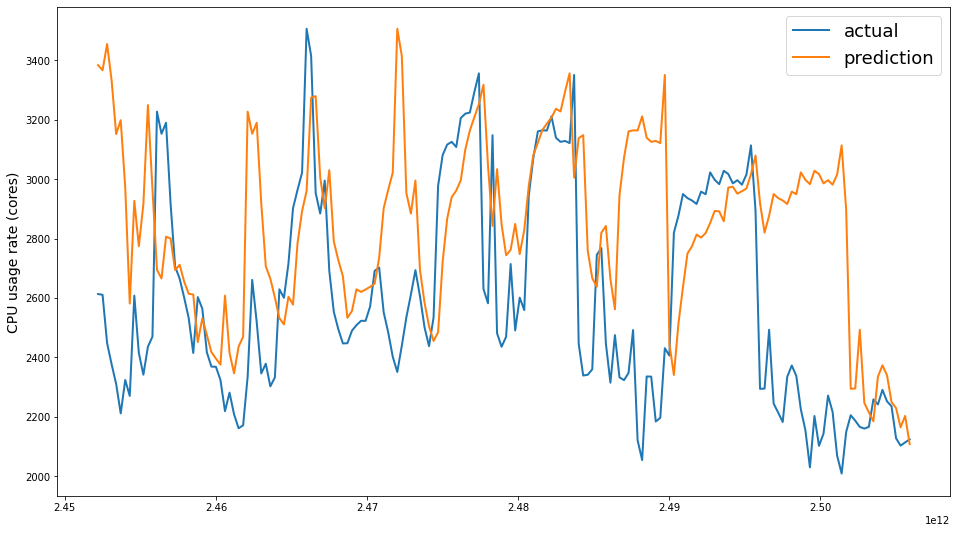

In [181]:
window=20
target_col='mean CPU usage rate'
targets = test[target_col][window:]


predsCmae = modelCmae.predict(X_train).squeeze()
predsTestCmae = modelCmae.predict(X_test).squeeze()

print(r2_score(predsCmae, y_train))
print(r2_score(predsTestCmae, y_test))

# convert change predictions back to actual price
predsTestCmae = test['mean CPU usage rate'].values[:-window] * (predsTestCmae + 1)
predsTestCmae = pd.Series(index=targets.index, data=predsTestCmae)

n = 180
line_plot(targets[-n:], predsTestCmae[-n:], 'actual', 'prediction')

0.8441557614432672
0.7750959330901627


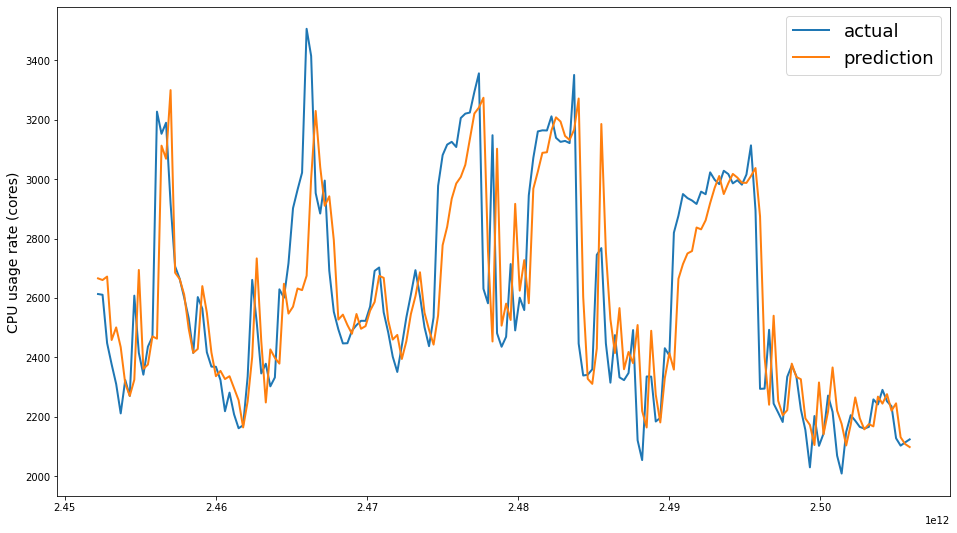

In [114]:
window=20
target_col='mean CPU usage rate'
targets = test[target_col][window:]


preds = model.predict(X_train).squeeze()
predsTest = model.predict(X_test).squeeze()

print(r2_score(preds, y_train))
print(r2_score(predsTest, y_test))

# convert change predictions back to actual price
predsTest = test['mean CPU usage rate'].values[:-window] * (predsTest + 1)
predsTest = pd.Series(index=targets.index, data=predsTest)

n = 180
line_plot(targets[-n:], predsTest[-n:], 'actual', 'prediction')

0.8717300056625633
0.7684028052341761


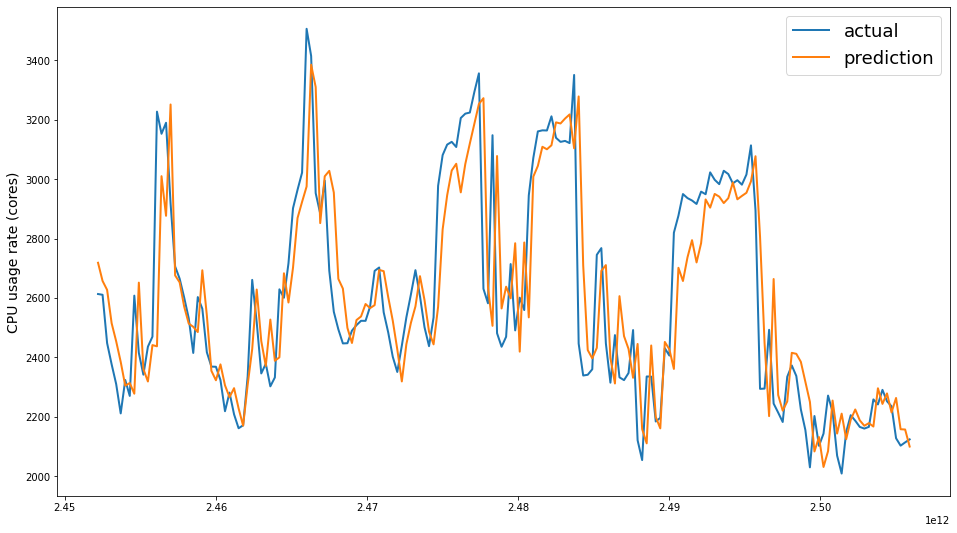

In [118]:
window=20
target_col='mean CPU usage rate'
targets = test[target_col][window:]


preds = modelMSE.predict(X_train).squeeze()
predsTest = modelMSE.predict(X_test).squeeze()

print(r2_score(preds, y_train))
print(r2_score(predsTest, y_test))

# convert change predictions back to actual price
predsTest = test['mean CPU usage rate'].values[:-window] * (predsTest + 1)
predsTest = pd.Series(index=targets.index, data=predsTest)

n = 180
line_plot(targets[-n:], predsTest[-n:], 'actual', 'prediction')

In [92]:
preds

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)